# ZRE Projekt 2022 — Spektra a RELP
### Alexander Polok
### xpolok03@fit.vutbr.cz

In [262]:
import numpy as np
import soundfile as sf
from IPython.display import Audio
import lib
import plots
import os

In [263]:
# Debugging purposes
# import importlib
#
# importlib.reload(lib)
# importlib.reload(plots)

# Úloha 1 - základy - 2 body
Načtěte řečový signál z https://www.fit.vutbr.cz/study/courses/ZRE/public/2021-22/a.wav (použijte vhodnou knihovnu ke čtení WAVek). Odečtěte střední hodnotu (tím se zbavíte stejnosměrné složky). Rozdělte jej na
rámce o délce 20 ms s nulovým překrytím (budou tedy těsně navazovat jeden na druhý). Vyberte pěkný znělý rámec, zobrazte ho a ručně určete periodu základního tónu ve vzorcích a v sekundách.

### Download source file and auxiliary functions

In [264]:
!wget https: // www.fit.vutbr.cz / study / courses / ZRE / public / 2021-22 / a.wav
!wget https: // www.fit.vutbr.cz / study / courses / ZRE / public / 2021-22 / features.py

--2022-04-12 21:26:38--  ftp://https/
           => ‘.listing’
Resolving https (https)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘https’
//: Scheme missing.
--2022-04-12 21:26:38--  http://www.fit.vutbr.cz/
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/ [following]
--2022-04-12 21:26:38--  https://www.fit.vut.cz/
Resolving www.fit.vut.cz (www.fit.vut.cz)... 147.229.9.26, 2001:67c:1220:809::93e5:91a
Connecting to www.fit.vut.cz (www.fit.vut.cz)|147.229.9.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.42’

index.html.42           [ <=>                ]  81.20K  --.-KB/s    in 0.03s   

2022-04-12 21:26:38 (2.61 MB/s) - ‘index.html.42’ saved [83150]

/:

In [265]:
# Load input file
input_file = 'a.wav'
sig, Fs = sf.read(input_file)
Audio(sig, rate=Fs)

In [266]:
# Subtract mean value from signal
print(f'Original mean: {np.mean(sig)}')
sig = sig - np.mean(sig)
print(f'New mean: {np.mean(sig)}')

# Signal framing
win_size = int(0.02 * Fs)  # 20ms
frames = lib.split_padded(sig, win_size)

Original mean: 0.00041165069563321596
New mean: 2.000918729178119e-18


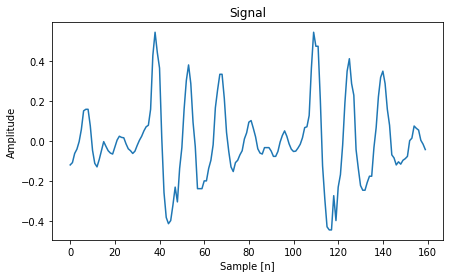

In [267]:
# Plot voiced frame
frame_to_plot = 7
frame_to_analyze = frames[frame_to_plot]
plots.plot_signal(frame_to_analyze)

### Lag is equal to (105-35) ~ 70 samples ∼ 70/Fs = 0,00875s ~ 1/70 * Fs = 114,29 Hz, which corresponds to the voice range of average man.

## Úloha 2 - spektrálnı́ hustota výkonu pomocı́ FFT - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ FFT. Výstup nechť je 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence (FFT tedy musı́te počı́tat na 256 vzrocı́ch - pokud je jich v rámci méně, použijte doplněnı́ nulami). Zobrazte logaritmus PSD vybraného rámce se slušnou frekvenčnı́ osou v Hz.

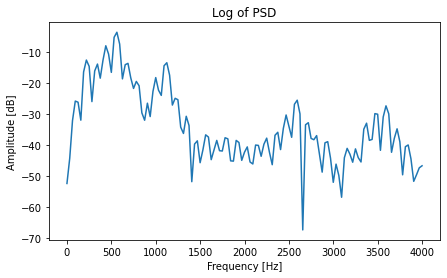

In [268]:
n_coef = 256
freq_to_show = 129
freq = np.linspace(0, Fs / 2, freq_to_show)

# Calculate power spectral density
psd = lib.psd_fft(frame_to_analyze, win_size, n_coef)[:freq_to_show]
psd_fft = 10 * np.log10(psd)
# Plot log of it from 0 to Fs/2
plots.plot_psd(psd_fft, freq)


## Úloha 3 - Odhad sady LPC filtrů - 2 body
Napište funkci pro odhad LPC filtru reprezentujı́ho daný rámec pomocı́ algoritmu Levinsona Durbina. Zajı́majı́
nás všechny filtry od řádu P = 1 až po P = 20. Nezapomeňte pro kažý filtr uložit i gain.

In [269]:
P = 10
A, G = lib.lpc(frame_to_analyze, P=P)

## Úloha 4 - analýza sady LPC filtrů - 2 body
Proveďte LPC analýzu vybraného znělého rámce pomocı́ všech LPC filtrů. Pro každý vygenerujte chybový signál lineárnı́ predikce e[n]. Spočı́tejte jeho energii. Ukažte závislost energie chybového signálu na řádu prediktoru. Ověřte že P = 10 je “rozumný” řád prediktoru.

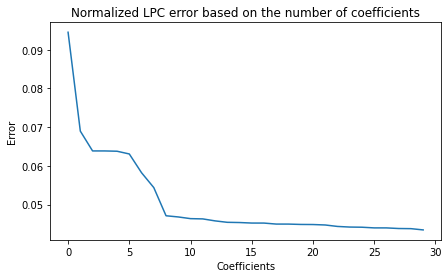

Error difference between 31 and 10 coefficients: 0.0033494026350408823


In [270]:
max_coefficients = 31
errors = [lib.lpc(frame_to_analyze, P=i)[1] for i in range(1, max_coefficients)]
plots.plot_lpc_errors(errors)

print(f'Error difference between {max_coefficients} and 10 coefficients: {errors[9] - errors[max_coefficients - 2]}')

### Error is "almost" stable from 7-8 coefficient, thus 10 is suitable option.

## Úloha 5 - spektrálnı́ hustota výkonu pomocı́ LPC - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ LPC filtru a jeho gainu. Výstup nechť je opět 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence. Zobrazte logaritmus PSD vybraného rámce pro vybraný řád filtru se slušnou frekvenčnı́ osou.

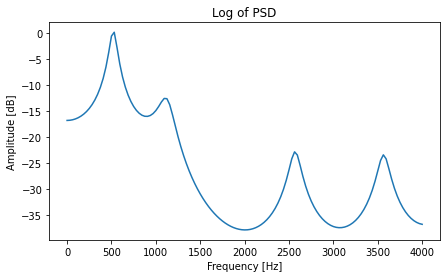

In [271]:
# Add 0th filter coefficient
A = np.append(1.0, A)
psd_lpc = 10 * np.log10(lib.psd_lpc(A, G, freq_to_show))
plots.plot_psd(psd_lpc, freq)

## Úloha 6 - spektrálnı́ hustota výkonu pomocı́ Mel banky filtrů - 2 body
Napište funkci pro odhad spektrálnı́ hustoty výkonu (power spectral density, PSD) pomocı́ Mel-banky filtrů s 23 filtry. Výstup nechť je opět 129 čı́sel od 0 do poloviny vzorkovacı́ frekvence. Zobrazte logaritmus PSD vybraného rámce se slušnou frekvenčnı́ osou. Využijte funkce z knihovny pytel2 .

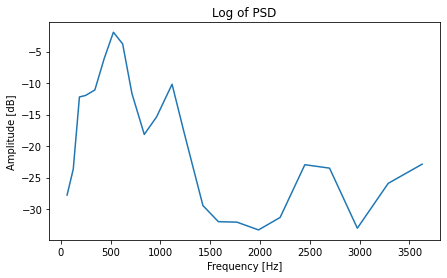

In [272]:
psd_mel, mel_freq = lib.psd_mel(frame_to_analyze, w_size=win_size, nfft=n_coef, Fs=Fs, show_freq=freq_to_show,
                                n_banks=23)
psd_mel = 10 * np.log10(psd_mel)
plots.plot_psd(psd_mel, mel_freq)

## Úloha 7 - Srovnánı́ PSD - 2 body
Ukažte (stále na vybraném rámci) všechny vypočı́tané PSD (pomocı́ FFT, Mel-banky filtrů a LPC pro alespoň 5 různých řádů filtrů) v jednom obrázku. Pokud “nesedı́” jejich úrovně, srovnejte je buď teoreticky (úprava gainů, atd.) nebo experimentálně. Komentujte frekvenčnı́ rozlišenı́ jednotlivých metod. Uveďte, kde vidı́me vliv hlasivek a kde artikulačnı́ho ústrojı́.

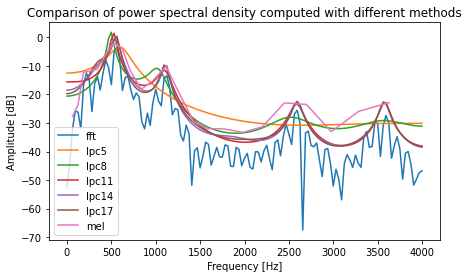

In [273]:
lpc_psds = [(lib.get_lpc_psd(*lib.lpc(frame_to_analyze, P=i), freq_to_show), f'lpc{i}') for i in range(5, 18, 3)]
plots.plot_psd_variants((freq, psd_fft), (freq, lpc_psds), (mel_freq, psd_mel))

### In FFT based power spectral density is possible to detect periodicity, with corresponds to the fundamental frequency of vocal tract. The influence of the vocal cords (whole larynx) is evident in the shape of the curve.
### In contrast, LPC and MFCC models a function of articulation, thus formants could be recognized. Cords influence should not be visible.

### MFCC are computed only on 23 filter banks, frequency resolution is poor, even not defined on the entire interval. Interpolation may be possible, but would not add any information to the graph. Frequency resolution of LPC, FFT PSD is same, on the axis X 129 values are visible.


## Úloha 8 - RELP - jen krátkodobá predikce - 5 bodů
Vytvořte funkci pro kódovánı́ – tvorbu signálu chyby lineárnı́ predikce (“residual”) pro celou nahrávku, po 20 ms budete měnit LPC koeficienty. Dejte pozor, abyste ve filtru A(z) neresetovali počátečnı́ podmı́nky, ale použili je z minulého rámce (prostudujte help k přı́slušné filtrovacı́ funkci nebo si ji napište sami). Zobrazte reziduál pro vybraný rámec, měli byste jasně vidět, že krátkodobé korelace (“vlnky”) vzniklé dı́ky rezonancı́m hlasového traktu v něm zmizely.

Vytvořte funkci pro dekódovánı́ – generovánı́ řeči z reziduálu pro celou nahrávku, po 20 ms budete měnit LPC koeficienty. Dejte pozor, abyste ve filtru 1/A(z) neresetovali počátečnı́ podmı́nky, ale použili je z minulého rámce (prostudujte help k přı́slušné filtrovacı́ funkci nebo si ji napište sami).

Vygenerujte signál po průchodu takovým kodekem a ověřte, že je shodný s originálem.

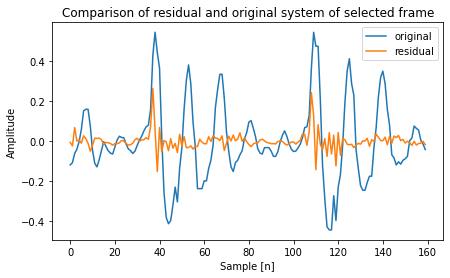

In [274]:
lpc_filters = [(lib.lpc(frame, P)) for frame in frames]
residuals = lib.get_residuals(frames, lpc_filters)
plots.plot_original_vs_residual(frame_to_analyze, residuals[frame_to_plot])

In [275]:
# Play original audio vs residuals
Audio(sig, rate=Fs)

In [276]:
Audio(np.hstack(residuals), rate=Fs)

In [277]:
sig_decoded = lib.decode_from_residuals(residuals, lpc_filters)
sig_dec_stacked = np.hstack(sig_decoded)
sig_orig = np.hstack(frames)
print(f'Absolute signal difference: {np.sum(np.abs(sig_dec_stacked - sig_orig))}')
Audio(sig_dec_stacked, rate=Fs)

Absolute signal difference: 6.679497178887356e-13


### Since the absolute difference is very small, it can be said that the signals are the same.

## Úloha 9 - RELP - včetně základnı́ho tónu - 5 bodů
Pokud se podı́váte na reziduál z úlohy 8, stále v něm uvidite “rány” způsobené hlasivkami, které se periodicky opakujı́. Výsledný reziduál tak nenı́ úplně vhodný na kódovánı́. V této úloze se jej pokuste dále “vybělit” (tak, aby se co nejvı́ce podobal bı́lému šumu) pomocı́ znalosti o periodě základnı́ho tónu. Můžete postupovat různě:
1. Odhadněte periodu základnı́ho tónu (viz cvičenı́) a analogicky ke krátkodobému prediktoru A(z) = 1 + a_{1}z^{−1} . . . a_{10}z^{−10} implementujte dlouhodobý prediktor B(z) = 1 + b_{1}z^{−L}, kde L je perioda základnı́ho tónu ve vzorcı́ch (lag). Koeficient b1 můžete natvrdo nastavit na 1, odvodit/najı́t vzoreček pro jeho výpočet, nebo najı́t dobrou hodnotu hrubou silou pomocı́ minimalizace energie “druhého” reziduálu po průchodu tı́mto filtrem.
2. Dlouhodobý prediktor B(z) můžete udělat i složitějšı́ s vı́ce koeficienty.
3. V historii krátkodobého reziduálu (na výstupu A(z)) pomocı́ korelace najı́t nejpodobnějšı́ úsek, zapamatovat si, jak daleko v historii je (pro znělé hlásky bude “jak daleko v historii je” odpovı́dat L!) a odečı́st ho.

Zı́skáte “druhý” reziduál. Zobrazte jej pro vybraný rámec a zkontrolujte, že je “bělějšı́” než ten krátkodobý.

Připravte si také funkci pro dekódovánı́ řeči (pro možnost 1 nebo 2 to bude filtrovánı́ filtrem 1/B(z), pro 3 přičtenı́ “druhého” reziduálu ke správnému úseku v historii).

Vygenerujte signál po průchodu takovým kodekem a ověřte, že je shodný s originálem.

### Second residuals are obtained by filtering with B(z) = 1 + b_{1}z^{−L}. Optimal lag is computed from nccf with limitation to only male lag range. b_{1} is simply set to -1.

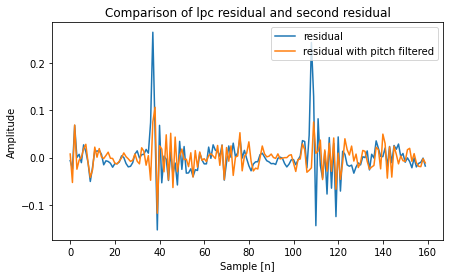

Original residual energy: 0.30553171946577584
Second residual energy: 0.12200028557621041
Detected lag: 71


In [278]:
L_min = int(1 / 180 * Fs)  #typicall male F0 range 85-180 HZ
L_max = int(1 / 85 * Fs)
residuals_prepended = np.pad(np.hstack(residuals), (L_max + 1, 0), constant_values=0)
residuals_filtered, lags = lib.get_second_residuals(L_max, L_min, threshold=0.4, residuals=residuals,
                                                    residuals_prepended=residuals_prepended, win_size=win_size)
plots.plot_residual_vs_residual2(residuals[frame_to_plot], residuals_filtered[frame_to_plot])
print(f'Original residual energy: {np.sum(residuals[frame_to_plot] ** 2)}')
print(f'Second residual energy: {np.sum(residuals_filtered[frame_to_plot] ** 2)}')
print(f'Detected lag: {lags[frame_to_plot]}')

In [279]:
decoded_residual = lib.decode_from_residuals2(residuals_filtered, lags, L_max)
decoded_orig_sig = np.hstack(lib.decode_from_residuals(decoded_residual, lpc_filters))
print(f'Absolute signal difference: {np.sum(np.abs(decoded_orig_sig - sig_orig))}')
Audio(decoded_orig_sig, rate=Fs)

Absolute signal difference: 6.908841717039732e-13


### The absolute difference is also very small, so it can be said that the signals are the same.

## Úloha 10 - RELP s kvantovánı́m - 5 bodů
Úkol je jednoduchý: stlačit počet bitů potřebných k zakódovánı́ celé nahrávky na minimum. Můžete použı́ cokoliv - jiné LPC parametry (PARCOR, LAR, LSF, cokoliv...), vektorové kvantovánı́, kvantovánı́ reziduálu nı́zkým počtem bitů, atd.

Popište, co jste dělali a jak nı́zko jste se dostali, aby byla nahrávka stále  rozumitelná. Do odevzdaného tgz dejte výslednou nahrávku a do protokolu počet bitů.

Nemusı́te implementovat bitové operace, pokud např. vı́te, že LPC koeficienty kvantujete VQ s kódovou knihou o velikosti 1024, gain skalárně na 4 bitech, lag na 8 bitech a reziduál na 1 bitu na vzorek, stačı́ počet bitů spočı́tat jako `Nr × (10 + 4 + 8 + 160 × 1)`, kde Nr je počet rámců.

## Coding to obtain good compression rate and quite good signal quality
### In the following examples, basic lpc coefficients are computed. Afterwards residuals and second order residuals are computed. Second order residuals are quantized to the `2^residual_bits` levels. Signal is further down sampled to obtain better compression rate.

In [280]:
# Encoder
residual_bits = 7
Fs = 4000
residuals_quantized, q_shift, q, min_val, lags, lpc_filters = lib.encode_wav(wav_file=input_file, Fs=Fs,
                                                                          win_size=int(0.02 * Fs), P=7,
                                                                          L_bounds=(
                                                                          int(1 / 180 * Fs), int(1 / 85 * Fs)),
                                                                          residual_bits=residual_bits, voiced_thr=0.7)
L_max = np.array(1 / 85 * Fs).astype(np.uint8)

In [281]:
original_size = os.path.getsize(input_file)
lib.print_compression_stats(original_size, residuals_quantized, lpc_filters, q_shift, q, lags, residual_bits, min_val,
                            L_max, None, None)

Original wav size = 61.97 kB
Coded signal size = 194 [Number_of_voiced_frames] * (2 [Gain, float_16] + 14 [LPC_filters, 7 float_16]+ 1 [Lag, uint_8] + 70.0 [Residual_quantized, 80 uint_7]) + 1 [q_shift, uint_8] + 4 [q, float_32] + 4 [min_val, float_32] 1 [L_max, uint_8] = 135104 bits = 16.89 kB
Compression ratio = 3.67


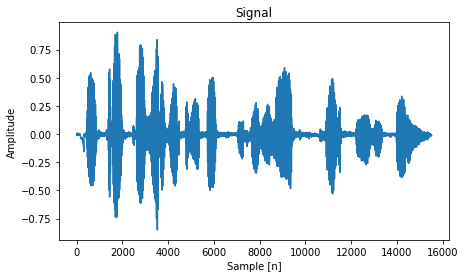

In [282]:
# Decoder
decoded_sig = lib.decode_wav(residuals_quantized, q_shift, q, min_val, lags, lpc_filters, L_max)
plots.plot_signal(decoded_sig)
Audio(decoded_sig, rate=Fs)

### Small bumps are audible in signal, but quality is quite good.

## Better compression rate by modeling unvoiced residuals with Gaussian noise

Original wav size = 61.97 kB
Coded signal size = 147 [Number_of_voiced_frames] * (2 [Gain, float_16] + 14 [LPC_filters, 7 float_16]+ 1 [Lag, uint_8] + 70.0 [Residual_quantized, 80 uint_7]) + 1 [q_shift, uint_8] + 4 [q, float_32] + 4 [min_val, float_32] 47 [Number_of_unvoiced_frames] * (4 [Gaussian mean, float32] + 4 [Gaussian std, float32]) + 188 [unvoiced_indexes, 47 uint_32] + 1 [L_max, uint_8] = 106904 bits = 13.36 kB
Compression ratio = 4.64


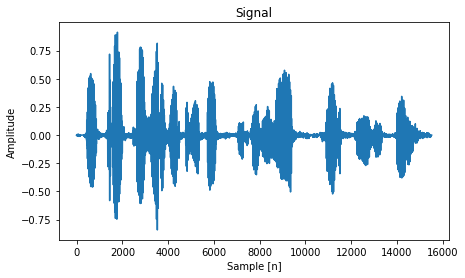

In [283]:
residual_bits = 7
Fs = 4000
win_size=int(0.02 * Fs)
voiced_quantized, q_shift, q, min_val, lags, unvoiced, unvoiced_indexes, lpc_filters = lib.encode_wav_gaussian(
    wav_file=input_file, Fs=Fs,
    win_size=win_size, P=7,
    L_bounds=(int(1 / 180 * Fs), int(1 / 85 * Fs)),
    residual_bits=residual_bits, voiced_thr=0.7)
L_max = np.array(1 / 85 * Fs).astype(np.uint8)
lib.print_compression_stats(original_size, voiced_quantized, lpc_filters, q_shift, q, lags, residual_bits, min_val,
                            L_max, unvoiced, unvoiced_indexes)
decoded_sig = lib.decode_wav_gaussian(voiced_quantized, unvoiced, unvoiced_indexes, q_shift, q, min_val, lags,
                                      lpc_filters, L_max, win_size)
plots.plot_signal(decoded_sig)
Audio(decoded_sig, rate=Fs)

### By modeling unvoiced residuals with Gaussian noise, compression ratio improves by 25%, without lost of quality.

## All residuals coded by Gaussian noise to obtain the best compression rate at the price of bad quality

Original wav size = 61.97 kB
Coded signal size = 194 [Number_of_unvoiced_frames] * (4 [Gaussian mean, float32] + 4 [Gaussian std, float32]) + 776 [unvoiced_indexes, 194 uint_32] + 1 [L_max, uint_8] = 18632 bits = 2.33 kB
Compression ratio = 26.61


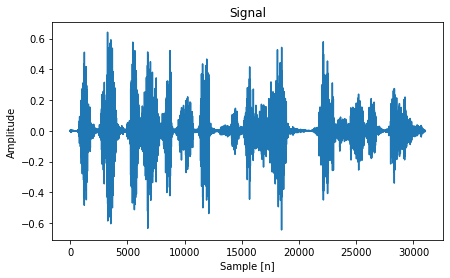

In [284]:
residual_bits = 10
Fs = 8000
win_size=int(0.02 * Fs)
voiced_quantized, q_shift, q, min_val, lags, unvoiced, unvoiced_indexes, lpc_filters = lib.encode_wav_gaussian(
    wav_file=input_file, Fs=Fs,
    win_size=win_size, P=7,
    L_bounds=(int(1 / 180 * Fs), int(1 / 85 * Fs)),
    voiced_thr=1.0, unvoiced_thr=1.0, residual_bits=residual_bits)
L_max = np.array(1 / 85 * Fs).astype(np.uint8)
lib.print_compression_stats(original_size, voiced_quantized, lpc_filters, q_shift, q, lags, residual_bits, min_val,
                            L_max, unvoiced, unvoiced_indexes)
decoded_sig = lib.decode_wav_gaussian(voiced_quantized, unvoiced, unvoiced_indexes, q_shift, q, min_val, lags,
                                      lpc_filters, L_max, win_size)
plots.plot_signal(decoded_sig)
Audio(decoded_sig, rate=Fs)

### Perfect compression ratio is obtained, but listening to that kind of signal for hours would be unpleasant.